The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


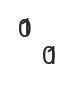

In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [27]:
from src.mutation_tools import pipeline_mutation_scores
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
df = pd.read_csv('../../pipeline/data/cedar_sample_200_scored_output.txt', sep =' ')
pepx = pd.read_csv('../../pipeline//data/cedar_sample_200_scored_output_wt_icore_pepx_output.csv')
merged=pd.merge(df, pepx.rename(columns={'peptide':'icore_wt_aligned'}), how='left', left_on='icore_wt_aligned', right_on='icore_wt_aligned')
merged.fillna(merged.median(skipna=True, numeric_only=True), inplace=True)
merged = pipeline_mutation_scores(merged, 'icore_mut','icore_wt_aligned', ics_kl, threshold=0.201, prefix='icore_')
merged.head()

,icore_start_pos,HLA,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,...,gene_num_proteins,gene_num_matching_proteins,gene_frac_matching_proteins,icore_len_mut,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score
0,1,HLA-A*0201,AVFYTILTPV,AVFYTILTV,0,8,1,0,0,AVFYTILTPV,...,NaN,NaN,NaN,10,10,"1,9",9,True,1,1
1,2,HLA-A*1101,YWFVNFETK,YWFVNFETK,0,0,0,0,0,YWFVNFETK,...,1,1,1.0,9,9,"1,8",1,True,2,-2
2,1,HLA-A*2402,IFFLGLILF,IFFLGLILF,0,0,0,0,0,IFFLGLILF,...,9,4,0.0,9,9,"1,8",2,False,2,-2
3,1,HLA-A*0301,ATPKYSNSLK,ATKYSNSLK,0,2,1,0,0,ATPKYSNSLK,...,2,2,1.0,10,10,"0,9",4,False,2,-3
4,1,HLA-B*1501,ASMTGIVY,ASM-TGIVY,0,0,0,3,1,ASMTGIVY,...,4;6,4;5,1.0;0.0,8,8,"1,7",6,False,4,0


In [36]:
cedar_aligned = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv').rename(columns={'icore_dissimilarity_score':'icore_similarity_score', 'Total_Gene_TPM':'total_gene_tpm'})
model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)

encoding_kwargs = dict(encoding='onehot', max_len=12, blosum_matrix=None, mask=True, invert=False, add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', threshold=0.201,
                       hla_col='HLA',add_aaprop=False,remove_pep=False, standardize=True, mut_col=['icore_similarity_score', 'icore_blsm_mut_score', 'total_gene_tpm'])
    # Training model and getting feature importances
print('Training')
trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_kl,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

In [37]:
# Saving trained models and the kwargs etc
import pickle
with open('../output/harmonic_model.pkl', 'wb') as f:
    data = {'model':trained_models,
            'kwargs':encoding_kwargs,
            'ics':ics_kl}
    pickle.dump(data, f)